In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio

from GCCM_gao import run_GCCM
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Data

In [2]:
# load data

x = rasterio.open('../Gao_code/raster/dTRI.tif')
xMatrix = x.read(1)
xMatrix = xMatrix.T
y = rasterio.open('../Gao_code/raster/Cu.tif')
yMatrix = y.read(1)
yMatrix = yMatrix.T

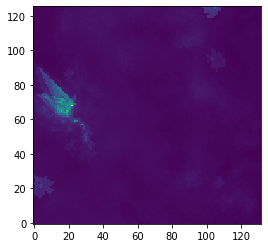

In [4]:
plt.imshow(yMatrix, origin='lower', interpolation='none')

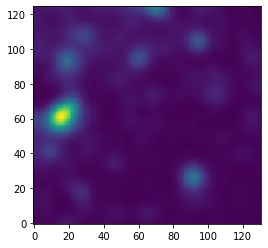

In [3]:
plt.imshow(xMatrix, origin='lower', interpolation='none')

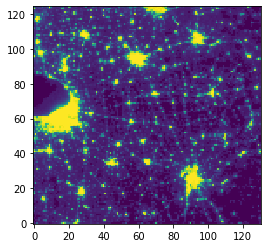

In [77]:
z = rasterio.open('../Gao_code/raster/nlights03.tif')
zMatrix = z.read(1)
zMatrix = zMatrix.T
plt.imshow(zMatrix, origin='lower', interpolation='none')

## Gao results

In [ ]:
lib_sizes = np.array([110])
#lib_sizes = np.arange(10,120,50)

# the dimensions of the embedding   
E = 3   
y_xmap_x_all, y_xmap_x_results = run_GCCM(xMatrix, yMatrix, lib_sizes, E, cores=None)

Constructing embedding
{'N': 625, 'rho': 0.020911997066866042, 'mae': 0.028634641984829966, 'rmse': 0.062267395428606875}
0 0 [nan nan nan ... nan nan nan] {'N': 625, 'rho': 0.020911997066866042, 'mae': 0.028634641984829966, 'rmse': 0.062267395428606875}
{'N': 625, 'rho': 0.06209981228686295, 'mae': 0.02887214640935175, 'rmse': 0.06189419571178796}
0 1 [nan nan nan ... nan nan nan] {'N': 625, 'rho': 0.06209981228686295, 'mae': 0.02887214640935175, 'rmse': 0.06189419571178796}
{'N': 625, 'rho': 0.062435967347401956, 'mae': 0.0293643105770734, 'rmse': 0.06237543331703374}
0 2 [nan nan nan ... nan nan nan] {'N': 625, 'rho': 0.062435967347401956, 'mae': 0.0293643105770734, 'rmse': 0.06237543331703374}
{'N': 625, 'rho': 0.07153760997952088, 'mae': 0.029144889260047584, 'rmse': 0.0617381135803855}
0 3 [nan nan nan ... nan nan nan] {'N': 625, 'rho': 0.07153760997952088, 'mae': 0.029144889260047584, 'rmse': 0.0617381135803855}
{'N': 625, 'rho': 0.07419048295644397, 'mae': 0.029103818817355024,

In [104]:
y_xmap_x_all

,L,rho
0,110,0.020912
1,110,0.062100
2,110,0.330466
3,110,0.373498


## Corrected results